<h1>8. Traveling through the USA<h1>


Reading data.

In [20]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

data_df = pd.read_csv('traveling_data.csv')
data_df

,City,Distance,Fare
0,Atlanta,576,178
1,Boston,370,138
2,Chicago,612,94
3,Dallas,1216,278
4,Detroit,409,158
5,Denver,1502,258
6,Miami,946,198
7,NewOrleans,998,188
8,NewYork,189,98
9,Orlando,787,179


a) Predicting Fare through Distance variable
--------------------------------------------

Reshaping data

In [21]:
X = data_df.Distance.array.reshape(-1,1)
y = data_df.Fare.array.reshape(-1,1)

Training Linear Regression Model

In [22]:
regressor_linear = LinearRegression()
regressor_linear.fit(X,y)
y_predicted = regressor_linear.predict(X)

Adding model prediction to the dataframe

In [23]:
y_predicted = y_predicted.reshape(1,-1)[0]
data_df["Prediction"] = y_predicted
data_df

,City,Distance,Fare,Prediction
0,Atlanta,576,178,150.875405
1,Boston,370,138,126.696136
2,Chicago,612,94,155.100908
3,Dallas,1216,278,225.995461
4,Detroit,409,158,131.273765
5,Denver,1502,258,259.564736
6,Miami,946,198,194.304187
7,NewOrleans,998,188,200.407692
8,NewYork,189,98,105.451245
9,Orlando,787,179,175.641548


Plotting data and predicted solution

--------------- No Values Dropped -------------
Mean squared error: 1192.40
Mean absolute error: 25.72
Coefficient of determination: 0.63
--------------------------------------


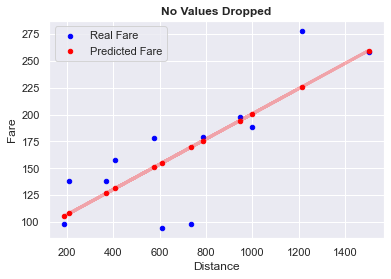

In [24]:
def train_and_get_results(new_data_df,dropped_cities,results,method,ax=None,print_info=False,line_color='red',draw_points=False):
    #Training model
    X = new_data_df.Distance.array.reshape(-1,1)
    y = new_data_df.Fare.array.reshape(-1,1)
    regressor_linear = LinearRegression()
    regressor_linear.fit(X,y)
    y_predicted = regressor_linear.predict(X)
    y_predicted = y_predicted.reshape(1,-1)[0]
    new_data_df["Prediction"] = y_predicted
    #For plotting prediction
    if ax!=None:
        if draw_points:
            new_data_df.plot(kind="scatter",x="Distance",y="Fare",c="blue",ax=ax)
            new_data_df.plot(kind="scatter",x="Distance",y="Prediction",ylabel="Fare",ax=ax,c=line_color)
        ax.legend(['Real Fare','Predicted Fare'])
        ax.plot(X, y_predicted, color=line_color, linewidth=3,alpha=0.3)
        ax.set_title(method,fontweight ="bold")
    #Getting different metrics
    mse = mean_squared_error(y, y_predicted)
    mae = mean_absolute_error(y, y_predicted)
    r2 = r2_score(y, y_predicted)
    if(print_info):
        print('---------------',method,'-------------')
        print("Mean squared error: %.2f" % mse)
        print("Mean absolute error: %.2f" % mae)
        print("Coefficient of determination: %.2f" % r2)
        print('--------------------------------------')
    #Saving results
    results[method]= {'MSE':round(mse,2),'MAE':round(mae,2),'R2':round(r2,2),'Dropped Cities':dropped_cities,'Coeff':round(regressor_linear.coef_[0][0],2),'Intercept':round(regressor_linear.intercept_[0],2)}
results = {}
figs, ax1 = plt.subplots(1, 1)
train_and_get_results(new_data_df=data_df,dropped_cities='None',results=results,method="No Values Dropped",ax=ax1,print_info=True,draw_points=True)

b) Detecting and treating outliers/extreme values to improve the model
-------------------------------------------------------------

Using the Interquartile Range Method (IQR)
------------------------------------------
An outlier is a data point that falls outside of 1.5 times of an Interquartile range above the 3rd quartile (Q3) and below the 1st quartile (Q1)

In [25]:
Q1=data_df['Fare'].quantile(0.25)
Q3=data_df['Fare'].quantile(0.75)
IQR=Q3-Q1
print('Q1:',Q1,'\nQ3:',Q3,'\nIQR:',IQR)
min_threshold = Q1-1.5*IQR
max_threshold = Q3+1.5*IQR
print('min:',min_threshold,'max:',max_threshold)

Q1: 128.0 
Q3: 190.5 
IQR: 62.5
min: 34.25 max: 284.25


<AxesSubplot:xlabel='Fare'>

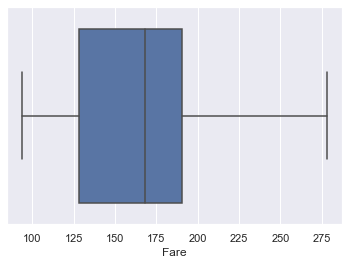

In [26]:
sns.boxplot(data=data_df,x="Fare")

This method does not work for our given dataset since we can't see any outliers defined by this method

Using the Standard Deviation Method.
----------------------------------

With this method, one can find outliers by identifying values which are as more than 3 standard deviations from the mean.  

In [27]:

data_mean, data_std = data_df['Fare'].mean(),data_df['Fare'].std()
threshold = data_std * 3
lower, upper = data_mean - threshold, data_mean + threshold
print('Lower threshold',lower)
print('Upper threshold',upper)
print('Fare Mean',data_mean)
print('Fare Std',data_std)


Lower threshold -11.446153042333947
Upper threshold 345.27948637566726
Fare Mean 166.91666666666666
Fare Std 59.454273236333535


In [28]:
data_df.describe()

,Distance,Fare,Prediction
count,12.000000,12.000000,12.000000
mean,712.666667,166.916667,166.916667
std,402.685831,59.454273,47.265285
min,189.000000,94.000000,105.451245
25%,399.250000,128.000000,130.129358
50%,674.500000,168.000000,162.436851
75%,959.000000,190.500000,195.830063
max,1502.000000,278.000000,259.564736


With this method we can see that no outlier is detected either.

Using Custom Methods to Treat Extreme Values
--------------------------------------------

Since no outliers were detected with the previous methods, a way to treat the abnormal values would be:

1) Find the values that are in quantile ranges $[0.0,0.10]$ and $[0.90,1.00]$.
2) Drop/Treat said values.

We will drop values according to the following criteria:

1) By Fare 
2) By Miles per Dollar
3) By Fare and Miles per Dollar

Additionally instead of dropping values, one could input a new fare in place of the extreme values, the new fare would be calculated as follows:

$dollarsPerMilesMean = 1/mean(milesPerDollar)$

$Fare_i = dollarsPerMilesMean*Miles_i$


<h2>Drop by Fare<h2>

In [29]:
lower_threshold=data_df['Fare'].quantile(0.10)
upper_threshold=data_df['Fare'].quantile(0.90)
mean = data_df['Fare'].mean()
print('lower_threshold:',lower_threshold,'upper_threshold:',upper_threshold)
new_data_df = data_df.copy(deep=True)
print(new_data_df)
print("-------Dropped Cities-----------")
dropped_cities_lower_index = new_data_df.City[new_data_df[new_data_df.Fare<=lower_threshold].index]
dropped_cities_upper_index = new_data_df.City[new_data_df[new_data_df.Fare>=upper_threshold].index]
dropped_cities = list(np.append(dropped_cities_lower_index.values,dropped_cities_upper_index.values))
dropped_cities =  ', '.join(dropped_cities)
print('Dropped lower threshold:\n',dropped_cities_lower_index)
print('Dropped upper threshold:\n',dropped_cities_upper_index)

new_data_df = new_data_df.drop(dropped_cities_lower_index.index)
new_data_df = new_data_df.drop(dropped_cities_upper_index.index)
new_data_df.describe()
drop_fare_data_df = new_data_df.copy(deep=True)
drop_fare_cities = dropped_cities

lower_threshold: 98.0 upper_threshold: 252.00000000000003
          City  Distance  Fare  Prediction
0      Atlanta       576   178  150.875405
1       Boston       370   138  126.696136
2      Chicago       612    94  155.100908
3       Dallas      1216   278  225.995461
4      Detroit       409   158  131.273765
5       Denver      1502   258  259.564736
6        Miami       946   198  194.304187
7   NewOrleans       998   188  200.407692
8      NewYork       189    98  105.451245
9      Orlando       787   179  175.641548
10  Pittsburgh       210   138  107.916122
11    St.Louis       737    98  169.772794
-------Dropped Cities-----------
Dropped lower threshold:
 2      Chicago
8      NewYork
11    St.Louis
Name: City, dtype: object
Dropped upper threshold:
 3    Dallas
5    Denver
Name: City, dtype: object


<h2>Drop by Miles per Dollar<h2>

          Distance        Fare  Prediction  miles_per_dollar
count    12.000000   12.000000   12.000000         12.000000
mean    712.666667  166.916667  166.916667          4.222152
std     402.685831   59.454273   47.265285          1.877743
min     189.000000   94.000000  105.451245          1.521739
25%     399.250000  128.000000  130.129358          2.658021
50%     674.500000  168.000000  162.436851          4.385374
75%     959.000000  190.500000  195.830063          5.436809
max    1502.000000  278.000000  259.564736          7.520408


<AxesSubplot:xlabel='miles_per_dollar'>

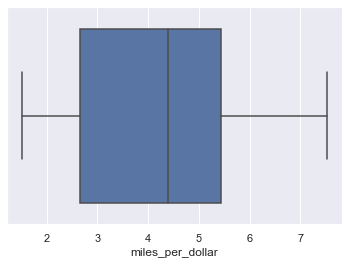

In [30]:

new_df = data_df.copy(deep=True)
new_df["miles_per_dollar"] = new_df.Distance/new_df.Fare
print(new_df.describe())
sns.boxplot(data=new_df,x="miles_per_dollar")

In [31]:
lower_threshold=new_df['miles_per_dollar'].quantile(0.10)
upper_threshold=new_df['miles_per_dollar'].quantile(0.90)
mean = new_df['miles_per_dollar'].mean()
print('lower_threshold:',lower_threshold,'upper_threshold:',upper_threshold)
new_data_df = new_df.copy(deep=True)
print(new_data_df)
print("-------Dropped Cities-----------")
dropped_cities_lower_index = new_data_df.City[new_data_df[new_data_df.miles_per_dollar<=lower_threshold].index]
dropped_cities_upper_index = new_data_df.City[new_data_df[new_data_df.miles_per_dollar>=upper_threshold].index]
dropped_cities = list(np.append(dropped_cities_lower_index.values,dropped_cities_upper_index.values))
dropped_cities =  ', '.join(dropped_cities)
print('Dropped lower threshold:\n',dropped_cities_lower_index)
print('Dropped upper threshold:\n',dropped_cities_upper_index)

new_data_df = new_data_df.drop(dropped_cities_lower_index.index)
new_data_df = new_data_df.drop(dropped_cities_upper_index.index)
new_data_df.describe()
drop_miles_data_df = new_data_df.copy(deep=True)
drop_miles_cities = dropped_cities

lower_threshold: 1.9945750452079567 upper_threshold: 6.441745010720766
          City  Distance  Fare  Prediction  miles_per_dollar
0      Atlanta       576   178  150.875405          3.235955
1       Boston       370   138  126.696136          2.681159
2      Chicago       612    94  155.100908          6.510638
3       Dallas      1216   278  225.995461          4.374101
4      Detroit       409   158  131.273765          2.588608
5       Denver      1502   258  259.564736          5.821705
6        Miami       946   198  194.304187          4.777778
7   NewOrleans       998   188  200.407692          5.308511
8      NewYork       189    98  105.451245          1.928571
9      Orlando       787   179  175.641548          4.396648
10  Pittsburgh       210   138  107.916122          1.521739
11    St.Louis       737    98  169.772794          7.520408
-------Dropped Cities-----------
Dropped lower threshold:
 8        NewYork
10    Pittsburgh
Name: City, dtype: object
Dropped upper thr

<h2>Drop by Fare and Miles per Dollar	<h2>

In [32]:
new_data_df = data_df.copy(deep=True)
print(new_data_df)
A = drop_miles_cities.split(", ")
B = drop_fare_cities.split(", ")
drop = list(set(A) & set(B))
dropped_cities =  ', '.join(drop)
print("-------Dropped Cities-----------\n",dropped_cities)
new_data_df = new_data_df.drop(new_data_df[data_df['City'].isin(drop)].index)

drop_intersec_data_df = new_data_df.copy(deep=True)
drop_intersec_cities = dropped_cities

          City  Distance  Fare  Prediction
0      Atlanta       576   178  150.875405
1       Boston       370   138  126.696136
2      Chicago       612    94  155.100908
3       Dallas      1216   278  225.995461
4      Detroit       409   158  131.273765
5       Denver      1502   258  259.564736
6        Miami       946   198  194.304187
7   NewOrleans       998   188  200.407692
8      NewYork       189    98  105.451245
9      Orlando       787   179  175.641548
10  Pittsburgh       210   138  107.916122
11    St.Louis       737    98  169.772794
-------Dropped Cities-----------
 St.Louis, NewYork, Chicago


<h2>Input Fare with Miles per Dollar Mean<h2>

In [33]:
input_df = new_df.copy(deep=True)
dollars_per_miles_mean = 1/input_df['miles_per_dollar'].mean()
print('dollars_per_miles_mean',dollars_per_miles_mean)
lower_threshold=data_df['Fare'].quantile(0.10)
upper_threshold=data_df['Fare'].quantile(0.90)
print('\n----------------Dataframes with new fares------------------\n')
mask = input_df.Fare<=lower_threshold
input_df.loc[mask,'Fare'] = dollars_per_miles_mean*new_df[mask].Distance
print(input_df[mask])
mask = input_df.Fare>=upper_threshold
input_df.loc[mask,'Fare'] = dollars_per_miles_mean*new_df[mask].Distance
print(input_df[mask])

dollars_per_miles_mean 0.23684605514747023

----------------Dataframes with new fares------------------

        City  Distance        Fare  Prediction  miles_per_dollar
2    Chicago       612  144.949786  155.100908          6.510638
8    NewYork       189   44.763904  105.451245          1.928571
11  St.Louis       737  174.555543  169.772794          7.520408
     City  Distance        Fare  Prediction  miles_per_dollar
3  Dallas      1216  288.004803  225.995461          4.374101
5  Denver      1502  355.742775  259.564736          5.821705


<h1>Final Results<h1>

<h3>Comparing Scores of Different Methods<h3>

In [39]:
train_and_get_results(new_data_df=drop_fare_data_df,dropped_cities=drop_fare_cities,results=results,method="Drop by Fare")
train_and_get_results(new_data_df=drop_miles_data_df,dropped_cities=drop_miles_cities,results=results,method="Drop by Miles per Dollar")
train_and_get_results(new_data_df=drop_intersec_data_df,dropped_cities=drop_intersec_cities,results=results,method="Drop by Fare and Miles per Dollar")
train_and_get_results(new_data_df=input_df,dropped_cities='None',results=results,method="Input Fare")

results_df = pd.DataFrame(results)
results_df.T

,MSE,MAE,R2,Dropped Cities,Coeff,Intercept
No Values Dropped,1192.4,25.72,0.63,None,0.12,83.27
Drop by Fare,62.39,6.56,0.87,"Chicago, NewYork, St.Louis, Dallas, Denver",0.07,123.09
Drop by Miles per Dollar,360.04,15.46,0.82,"NewYork, Pittsburgh, Chicago, St.Louis",0.11,103.56
Drop by Fare and Miles per Dollar,329.66,14.45,0.84,"St.Louis, NewYork, Chicago",0.11,108.29
Input Fare,867.55,27.0,0.84,None,0.18,55.76


We can see that with any method we improve the model but by dropping the cities with extreme fare values we get the best performing model according to MSE, MAE and R2 scores. 

<h3>Comparing Regression Lines<h3>

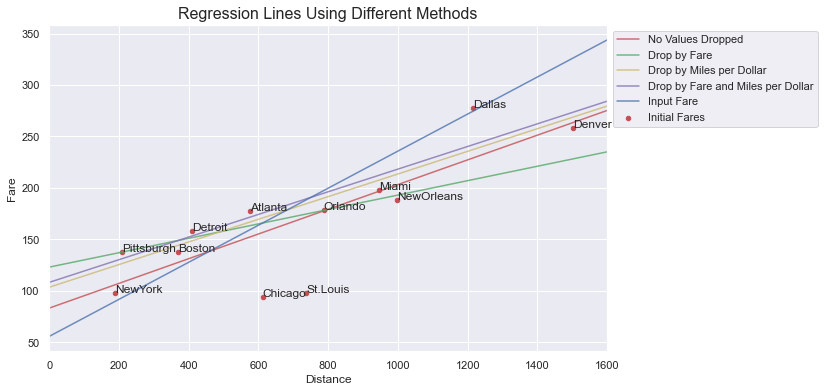

In [35]:
def draw_line(intercept,coef,ax,color):
    y_vals = intercept + coef * x_vals
    ax.plot(x_vals, y_vals,alpha=0.8,label=labels[i],color=color)

lines_data = results_df.T[["Coeff", "Intercept"]]
ax = plt.gca()
ax.set_xlim(0,1600)
x_vals = np.array(ax.get_xlim())
labels = results_df.T.index.array
labels = list(labels)+["Initial Fares"]
colors = ['r','g','y','m','b']
for i in range(5):
    draw_line(lines_data["Intercept"].array[i],lines_data["Coeff"].array[i],ax,colors[i])
data_df.plot(kind='scatter',x='Distance',y='Fare',ax=ax,color='r')
ax.set_title('Regression Lines Using Different Methods', fontsize=16)
for k, v in data_df[["Distance","Fare"]].iterrows():
    ax.annotate(data_df.City.iloc[k], v)
ax.legend(labels,bbox_to_anchor=(1, 1))
ax.figure.set_size_inches(10,6)

Here we can visually inspect for each method which cities affect the most to each regression line, for example we can see that the slopes for the methods involving miles per dollar drop cities closer to either axis but does not drop extreme values like Dallas or Denver.

We can also see that by inputting new fares using the average of $dollars/miles$  it would give us a model that predicts higher prices than the other models which maybe for some distance would give an excessively expensive fare.

